In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# 1. 이상치 처리 클래스 
class CustomWinsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=[0.05, 0.05]):
        self.limits = limits
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        from scipy.stats.mstats import winsorize
        X_copy = X.copy()
        if isinstance(X_copy, pd.DataFrame):
            for col in X_copy.columns:
                X_copy[col] = winsorize(X_copy[col], limits=self.limits)
        else:
            X_copy = winsorize(X_copy, limits=self.limits)
        return X_copy

# 2. 파생변수 생성 함수 
def add_custom_features(df):
    X = df.copy()
    X['HasBalance'] = (X['Balance'] > 0).astype(int)
    X['BalanceSalaryRatio'] = X['Balance'] / (X['EstimatedSalary'] + 1e-6)
    X['Age_Group'] = pd.cut(X['Age'], bins=[0, 30, 45, 60, 100], labels=[0, 1, 2, 3]).astype(int)
    X['Prod_is_1'] = (X['NumOfProducts'] == 1).astype(int)
    X['Prod_is_2'] = (X['NumOfProducts'] == 2).astype(int)
    X['Prod_ge_3'] = (X['NumOfProducts'] >= 3).astype(int)
    X['ZeroBal_Prod2'] = ((X['Balance'] == 0) & (X['NumOfProducts'] == 2)).astype(int)
    X['ZeroBal_Prod1'] = ((X['Balance'] == 0) & (X['NumOfProducts'] == 1)).astype(int)
    X['Prod2_Inactive'] = ((X['NumOfProducts'] == 2) & (X['IsActiveMember'] == 0)).astype(int)
    X['Inactive_Old'] = ((X['IsActiveMember'] == 0) & (X['Age'] >= 45)).astype(int)
    X['DangerFlag'] = ((X['Complain'] == 1) & (X['Satisfaction Score'] <= 2)).astype(int)
    return X

# 3. 데이터 로드 및 분할 (6:2:2)
df = pd.read_csv('Customer-Churn-Records.csv')
X = df.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
y = df['Exited']

# 1차 분할: Train_Full(80%) / Test(20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2차 분할: Train_Full을 다시 Train(60%) / Val(20%)로 나눔 
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

# 4. 파이프라인 적용
# 수치형 변수 리스트 (파생변수 생성 전 기준)
num_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Point Earned']
cat_cols = ['Geography', 'Gender', 'Card Type']
pass_cols = ['HasBalance', 'Age_Group', 'IsActiveMember', 'Complain', 'NumOfProducts', 
             'Prod_is_1', 'Prod_is_2', 'Prod_ge_3', 'ZeroBal_Prod2', 'ZeroBal_Prod1', 
             'Prod2_Inactive', 'Inactive_Old', 'DangerFlag']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('winsorizer', CustomWinsorizer()),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('pass', 'passthrough', pass_cols)
])

# 5. 각 데이터셋 전처리 실행
# 훈련 데이터에 먼저 파생변수 추가
X_train_enriched = add_custom_features(X_train)
X_val_enriched = add_custom_features(X_val)
X_test_enriched = add_custom_features(X_test)

# 파이프라인 통과 (fit은 Train 데이터만)
X_train_final = preprocessor.fit_transform(X_train_enriched)
X_val_final = preprocessor.transform(X_val_enriched)
X_test_final = preprocessor.transform(X_test_enriched)

# 6. 최종 파일 저장
pd.DataFrame(X_train_final).to_csv('X_train.csv', index=False)
pd.DataFrame(X_val_final).to_csv('X_val.csv', index=False)
pd.DataFrame(X_test_final).to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

print(f"✅ 데이터 3분할 완료!")
print(f"Train: {X_train_final.shape}, Val: {X_val_final.shape}, Test: {X_test_final.shape}")

✅ 데이터 3분할 완료!
Train: (6000, 27), Val: (2000, 27), Test: (2000, 27)


C:\Users\playdata2\miniconda3\Lib\site-packages\xgboost\training.py:200: UserWarning: [10:10:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- 📊 Validation Set Performance ---
AUC: 0.9993
Recall: 1.0000
F1-Score: 0.9963

--- 🏁 Test Set Performance (최종 성적) ---
AUC: 0.9965
Recall: 0.9951
F1-Score: 0.9963


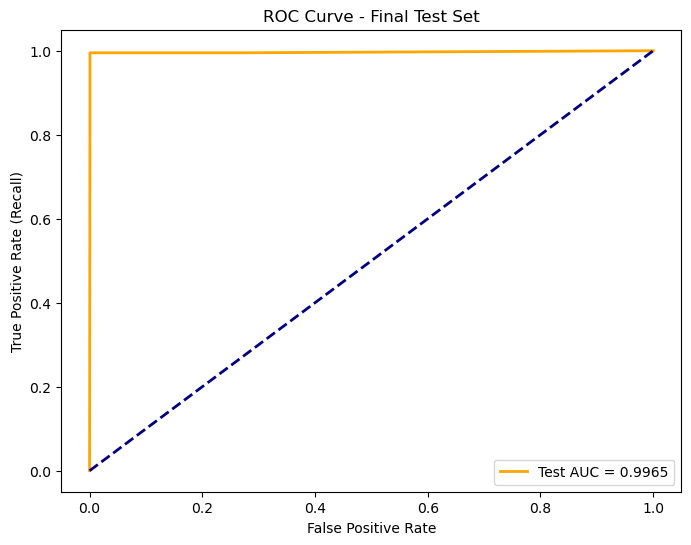

In [3]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, f1_score, recall_score
import matplotlib.pyplot as plt

# 1. 모델 정의 (이탈자 가중치 부여 및 하이퍼파라미터 설정)
# 클래스 불균형 해소를 위해 scale_pos_weight 계산
ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]

model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=4,  # 불균형 데이터 처리
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 2. 모델 학습 (Train 세트로 학습)
model.fit(X_train_final, y_train)

# 3. 예측 및 확률값 계산
# (Validation 데이터)
val_probs = model.predict_proba(X_val_final)[:, 1]
val_pred = (val_probs >= 0.5).astype(int) # Recall 확보를 위해 임계값 0.4 적용

# (Test 데이터)
test_probs = model.predict_proba(X_test_final)[:, 1]
test_pred = (test_probs >= 0.5).astype(int)

# 4. 성능 지표 출력
print("--- 📊 Validation Set Performance ---")
print(f"AUC: {roc_auc_score(y_val, val_probs):.4f}")
print(f"Recall: {recall_score(y_val, val_pred):.4f}")
print(f"F1-Score: {f1_score(y_val, val_pred):.4f}")

print("\n--- 🏁 Test Set Performance (최종 성적) ---")
print(f"AUC: {roc_auc_score(y_test, test_probs):.4f}")
print(f"Recall: {recall_score(y_test, test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, test_pred):.4f}")

# 5. 시각화 (ROC Curve)
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.plot(fpr, tpr, color='orange', lw=2, label=f'Test AUC = {roc_auc_score(y_test, test_probs):.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve - Final Test Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc="lower right")
plt.show()

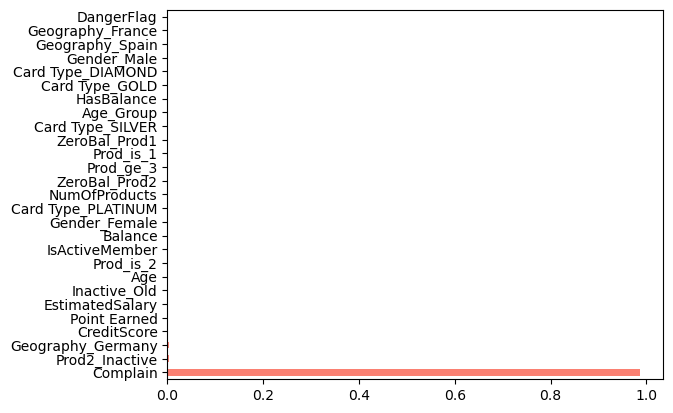

In [4]:
# 전처리 후 생성된 컬럼명 추출 (OneHotEncoding 대응)
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols).tolist()
all_features = num_cols + cat_feature_names + pass_cols

# 중요도 시각화
importances = pd.Series(model.feature_importances_, index=all_features)
importances.sort_values(ascending=False).plot(kind='barh', color='salmon')
plt.show()